# Lab 4. Konwolucje

Zadanie dla Państwa na te ćwiczenia (z dokończeniem jako praca domowa) to implementacja funkcji konwolucji oraz max pooling dla obrazów.

In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt

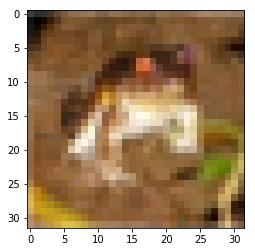

In [2]:
# load data
cifar_sample = np.load('utils/cifar_sample.npy')
# get first random image and plot it
sample_image = cifar_sample[0]
plt.imshow(sample_image.transpose(1, 2, 0))

### Wzory na rozmiary
**Pytanie 1**: Jaki będzie rozmiar obrazka na wyjściu konwolucji/poolingu przy parametrach poniżej.  
**Uwaga**: zarówno we wzorach jak i w kodzie używana jest torchowa konwencja *channel first*.

Stride: $ \hspace{95px} S $  
Padding: $ \hspace{80px} P $  
Obrazek wejściowy: $ \hspace{12px} C_i \times H_i \times W_i$  
Filtry: $ \hspace{100px} K \times C_f \times F \times F $  

Gdzie: $C_i$ to liczba kanału obrazu wejściowego, $H_i, W_i$ to odpowiednio wysokość i szerokość obrazu wejściowego. $K$ to liczba filtrów, $C_f$ liczba kanałów w każdym filtrze, $F$ to zarówno wysokość jak i szerokość filtra (rozważami tylko filtry kwadratowe).

Obrazek wyjściowy: $ \hspace{15px} C_o \times H_o \times W_o $  


$ \hspace{140px} C_o = ??? $  
$ \hspace{140px} H_o = ??? $  
$ \hspace{140px} W_o = ??? $  

**Pytanie 2**: Ile wag (floatów) ma taka warstwa konwolucyja?  

### Wizualna pomoc do konwolucji
[Źródło](http://cs231n.github.io/convolutional-networks/)

<img src="./utils/cnn.gif"></img>

### Zadanie
Zadaniem jest zaimplementowanie funkcji konwolucji i poolingu dla obrazku 2D. Implementacja nie musi być optymalna pod względem złożoności czasowej (tzn. można/zaleca się używanie pętli). 

Warunkiem zaliczenia zadania jest przejście komórek testowych dla konwolucji i poolingu. W razie problemów polecam zacząć od poolingu, który w idea jest podobny do konwolucji, lecz mniej skomplikowany.

### Konwolucja

In [3]:
def convolution(image: torch.tensor,
                filters: torch.tensor,
                bias: torch.tensor,
                stride: int = 1,
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param filters: torch.Tensor 
        Filters to use in convolution of shape (K, C, F, F)
    :param bias: torch.Tensor 
        Bias vector of shape (K,)
    :param stride: int
        Stride to use in convolution
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape
    n_filters, filter_channels, filter_size, filter_size = filters.shape
    # calculate the dimensions of the output image
    out_height = int((img_height - filter_size + 2 * padding) / stride + 1)
    out_width = int((img_width - filter_size + 2 * padding) / stride + 1)
    out_channels = int(n_filters)

    if padding:
        zero_padding = torch.nn.ZeroPad2d(padding)
        image = zero_padding(image)

    out = []
    for f in range(n_filters):
        values_for_filter = []
        for h in range(filter_size, image.shape[1] + 1, stride):
            for w in range(filter_size, image.shape[2] + 1, stride):
                sum_convolution_for_channels = []
                for ch in range(img_channels):
                    convolution = torch.sum(image[ch, h - filter_size:h, w - filter_size:w] * filters[f][ch])
                    sum_convolution_for_channels.append(convolution.item())
                values_for_filter.append(sum(sum_convolution_for_channels) + bias[f].item())
        out.append(torch.Tensor(values_for_filter).reshape(out_height, out_width))
    return torch.stack(out, dim=0)

In [4]:
### Convolution Test ### 

from itertools import product
from tqdm import tqdm_notebook as tqdm

# cast the frog to tensor
image = torch.tensor(np_image)
# prepare parameters for testing
paddings = [0, 1, 2, 3]
strides = [1, 2, 3, 4]
filters = [(torch.randn((2, 3, 3, 3)), torch.zeros((2))),
           (torch.randn((2, 3, 5, 5)), torch.zeros((2))),
           (torch.randn((5, 3, 1, 1)), torch.zeros((5)))]

# test all combinations
for (filt, bias), stride, padding in tqdm(product(filters, strides, paddings), total=4 * 4 * 3):
    # your convolution
    out = convolution(image, filt, bias, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.conv2d(input=image.unsqueeze(0), weight=filt, bias=bias, padding=padding, stride=stride)
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

### Max Pooling

In [5]:
def max_pooling(image: torch.tensor,
                kernel_size: int,
                stride: int = 1,
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param kernel_size: int 
        Size of the square pooling kernel
    :param stride: int
        Stride to use in pooling
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape
    # calculate the dimensions of the output image
    out_height = int((img_height - kernel_size + 2 * padding) / stride + 1)
    out_width = int((img_width - kernel_size + 2 * padding) / stride + 1)
    out_channels = int(img_channels)

    if padding:
        zero_padding = torch.nn.ZeroPad2d(padding)
        image = zero_padding(image)

    max_values_in_each_channel = []
    for ch in range(out_channels):
        max_values_in_current_channel = []
        for h in range(kernel_size, image.shape[1] + 1, stride):
            for w in range(kernel_size, image.shape[2] + 1, stride):
                max_values_in_current_channel.append(torch.max(image[ch, h - kernel_size:h, w - kernel_size:w]))
        max_values_in_current_channel = torch.Tensor(max_values_in_current_channel).reshape(out_height, out_width)
        max_values_in_each_channel.append(max_values_in_current_channel)
    return torch.stack(max_values_in_each_channel, dim=0)

In [6]:
### Max Pooling Test ###

from itertools import product
from tqdm import tqdm_notebook as tqdm

# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
kernel_sizes = [2, 3, 4]
paddings = [0, 1]
strides = [1, 2, 3, 4]

# test all combinations
for kernel_size, stride, padding in tqdm(product(kernel_sizes, strides, paddings), total=3 * 2 * 4):
    # your pooling
    out = max_pooling(image, kernel_size=kernel_size, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.nn.functional.max_pool2d(input=image.unsqueeze(0), kernel_size=kernel_size, padding=padding,
                                               stride=stride)
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)